In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [5]:
sc = SparkContext("local", "MLCancerDiagnosis")
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 21:10:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
cancer_data = spark.read.csv("./project3_data.csv", header=True, inferSchema=True)

In [7]:
cancer_data.limit(5).toPandas()

23/12/04 21:10:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,21.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
indexer = StringIndexer(inputCol = "diagnosis", outputCol = "label")
cancer_data_indexed = indexer.fit(cancer_data).transform(cancer_data)

In [9]:
feature_columns = [col for col in cancer_data.columns if col != "diagnosis"]

In [10]:
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")

In [11]:
cancer_data_assembled = assembler.transform(cancer_data_indexed)

In [12]:
(training_data, test_data) = cancer_data_assembled.randomSplit([0.75, 0.25], seed = 32)

## Random Forest

In [13]:
#define model

In [14]:
rf_classifier = RandomForestClassifier(labelCol = "label", featuresCol = "features", seed=32)

In [15]:
#create Pipelines

In [16]:
rf_pipeline = Pipeline(stages=[rf_classifier])

In [17]:
#train model

In [18]:
rf_model = rf_pipeline.fit(training_data)

In [19]:
#make the predictions

In [20]:
rf_predictions = rf_model.transform(test_data)

In [21]:
#evaluate the model

In [22]:
evaluator = BinaryClassificationEvaluator(labelCol="label")

In [23]:
#area under the curve

In [24]:
rf_auc = evaluator.evaluate(rf_predictions)

In [25]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol= "label", predictionCol = "prediction", metricName= "f1")

In [26]:
rf_f1 = multi_evaluator.evaluate(rf_predictions)

In [27]:
rf_precision = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedPrecision"})
rf_recall = multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedRecall"})

In [28]:
#print metrics

In [29]:
print(f"f1 score:{rf_f1}")

f1 score:0.9548872180451128


In [30]:
print(f"Precision: {rf_precision}")

Precision: 0.9548872180451128


In [31]:
print(f"Recall: {rf_recall}")

Recall: 0.9548872180451128


In [32]:
def plot_roc_curve(predictions, title):
    predictions_pd = predictions.select("label", "probability").toPandas()

    y_true = predictions_pd["label"]
    y_scores = predictions_pd["probability"].apply(lambda x: x[1])

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: 

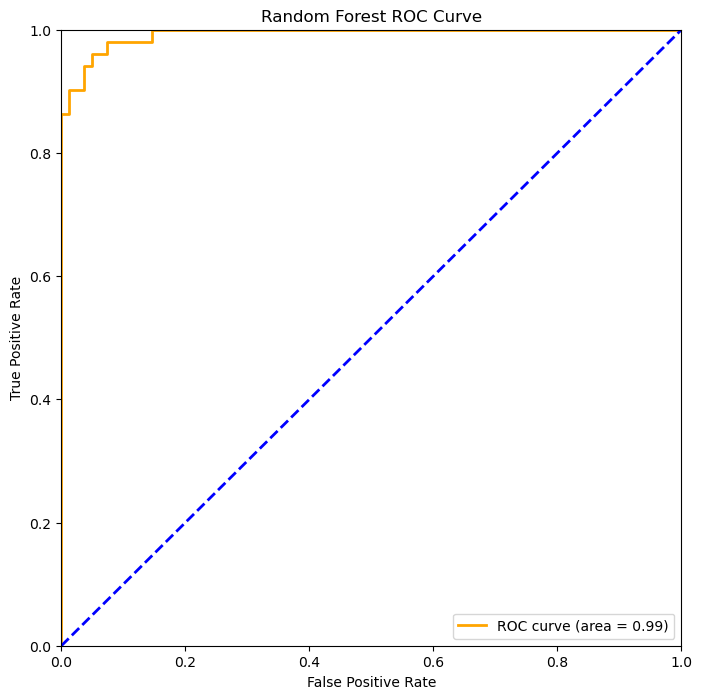

In [33]:
plot_roc_curve(rf_predictions, "Random Forest ROC Curve")

## Logistic Regression

In [34]:
lr_classifier = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 12, regParam = 0.3, elasticNetParam=0.8)

In [35]:
lr_pipeline = Pipeline(stages=[lr_classifier])

In [36]:
lr_model = lr_pipeline.fit(training_data)

23/12/04 21:10:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [37]:
lr_predictions = lr_model.transform(test_data)

In [38]:
evaluator = BinaryClassificationEvaluator(labelCol="label")
lr_auc = evaluator.evaluate(lr_predictions)
multi_evaluator = MulticlassClassificationEvaluator(labelCol= "label", predictionCol = "prediction", metricName= "f1")
lr_f1 = multi_evaluator.evaluate(lr_predictions)
lr_precision = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedPrecision"})
lr_recall = multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedRecall"})

In [39]:
print(f"f1 score:{lr_f1}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")

f1 score:0.8482078195686729
Precision: 0.884016973125884
Recall: 0.8571428571428571


/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/elawieczorek/miniconda3/envs/ml_cancer_diagnosis/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: 

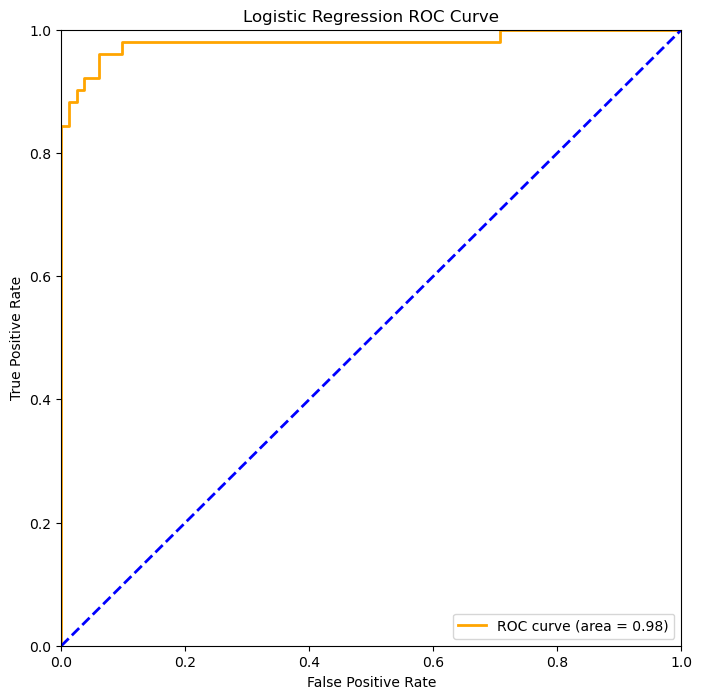

In [41]:
plot_roc_curve(lr_predictions, "Logistic Regression ROC Curve")